# Changes compared to previous Notebook

* I do not call fit_transform for the test data again in the pipeline - preprocessing the features and transforming in the pipeline are separate steps now
* I changed "0" values in the Fare to "NaN" and impute to the median afterwards
* I use a StandardScaler() for the Fare

In [550]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, StandardScaler

# Build a Pipeline

## Central methods to call on the data

In [551]:
def load_titanic_data():
    return pd.read_csv(os.path.join('data', 'train.csv'))

def split_data(df):
    stratify_by = df["Pclass"]
    titanic_train, titanic_test = train_test_split(df, test_size=0.2, stratify=stratify_by, random_state=42)
    titanic_train_features = titanic_train.drop('Survived', axis=1)
    titanic_train_label = titanic_train['Survived']
    titanic_test_features = titanic_test.drop('Survived', axis=1)
    titanic_test_label = titanic_test['Survived']
    return titanic_train_features, titanic_train_label, titanic_test_features, titanic_test_label

In [552]:
titanic = load_titanic_data()
# we call the train set just "titanic"
X_train, y_train, X_test, y_test = split_data(titanic)

## Analyze the data

See Notebook titanic-kaggle-analyze

## Preprocess the data

In [553]:
def drop_columns(df):
    columns_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
    return df.drop(columns_to_drop, axis=1)

In [554]:
def sex_pipeline():
    # we are going to use an OrdinalEncoder to make numerical data of the sex
    return Pipeline([
        ("encode", OrdinalEncoder())
    ])

In [555]:
def age_pipeline():
    # since there are lots of null values we are going to impute them
    return Pipeline([
        ("impute", SimpleImputer(strategy="median"))
    ])

In [556]:
def transform_sipsp_parch(df):
    # from SibSp and Parch, we create a new column "Alone"
    # Create a mask for the conditions
    mask = (df["SibSp"] == 0) & (df["Parch"] == 0)

    # Create a new column, initialized with 1
    df.loc[:, "Alone"] = 1

    df.loc[~mask, "Alone"] = 0 # set 0 where the condition is not met
    df = df.drop(["SibSp", "Parch"], axis=1)
    return df

In [557]:
def embarked_pipeline():
    # we impute the null values with the most frequent and afterward encode it
    return  Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder())
    ])


In [558]:
def fare_pipeline():
    # we impute the null values with the median
    return Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ])

In [559]:
def preprocess_feature(X):
    # drop the columns
    X = drop_columns(X)

    # create column "Alone" from ["SibSp", "Parch"]
    transformer = FunctionTransformer(transform_sipsp_parch)
    X = transformer.transform(X)

    # since we have "0" values in Fare, we replace them with "NaN" (the imputer in the pipeline will change those afterwards)
    X['Fare'] = X['Fare'].replace(0, np.nan)

    return X


def apply_pipeline(X, pipeline):
    # here we do only a "transform", no "fit"!
    return pd.DataFrame(pipeline.transform(X), columns=pipeline.get_feature_names_out(), index=X.index)


transformers = [
    ('Sex', sex_pipeline(), ['Sex']),
    ('Age', age_pipeline(), ['Age']),
    ('Embarked', embarked_pipeline(), ['Embarked']),
    ('Fare', fare_pipeline(), ['Fare'])
]

# Create the ColumnTransformer
ct = ColumnTransformer(transformers, remainder="passthrough")

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ("preprocessor", ct)
])

X_train = preprocess_feature(X_train)

# fit the pipeline on the preprocessed features
preprocessing_pipeline.fit(X_train)

# apply the pipeline
X_train = apply_pipeline(X_train, preprocessing_pipeline)

In [560]:
X_train.head(10)

,Sex__Sex,Age__Age,Embarked__Embarked,Fare__Fare,remainder__Pclass,remainder__Alone
820,0.0,52.0,2.0,1.257206,1.0,0.0
439,1.0,31.0,2.0,-0.454550,2.0,1.0
821,1.0,27.0,2.0,-0.492446,3.0,1.0
403,1.0,28.0,2.0,-0.344214,3.0,0.0
343,1.0,25.0,2.0,-0.402991,2.0,1.0
514,1.0,24.0,2.0,-0.516507,3.0,1.0
40,0.0,40.0,2.0,-0.475689,3.0,0.0
101,1.0,28.0,2.0,-0.508258,3.0,1.0
93,1.0,26.0,2.0,-0.246767,3.0,0.0
81,1.0,29.0,2.0,-0.475173,3.0,1.0


# Train the data

## LogisticRegression

In [561]:
lr_model = LogisticRegression(max_iter=1000, penalty=None)
lr_model.fit(X_train, y_train)
print("The score of our model is ", lr_model.score(X_train, y_train))

The score of our model is  0.7963483146067416


# Test the data

In [562]:
# preprocess the test data
X_test = preprocess_feature(X_test)

# apply the pipeline
X_test = apply_pipeline(X_test, preprocessing_pipeline)

X_test.head(10)

,Sex__Sex,Age__Age,Embarked__Embarked,Fare__Fare,remainder__Pclass,remainder__Alone
132,0.0,47.0,2.0,-0.372056,3.0,0.0
3,0.0,35.0,2.0,0.424014,1.0,0.0
270,1.0,28.0,2.0,-0.031767,1.0,1.0
421,1.0,21.0,1.0,-0.511609,3.0,1.0
154,1.0,28.0,2.0,-0.520287,3.0,1.0
292,1.0,36.0,0.0,-0.405569,2.0,1.0
304,1.0,28.0,2.0,-0.505078,3.0,1.0
202,1.0,34.0,2.0,-0.537131,3.0,1.0
810,1.0,26.0,2.0,-0.508429,3.0,1.0
108,1.0,38.0,2.0,-0.508258,3.0,1.0


In [563]:
final_predictions = lr_model.predict(X_test)

## Final Scores

In [564]:
cm = confusion_matrix(y_test, final_predictions)
cm

array([[92, 25],
       [18, 44]], dtype=int64)

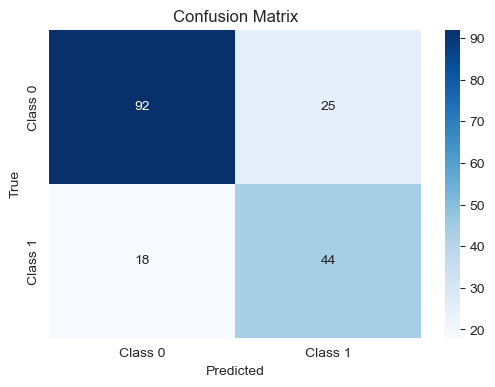

In [565]:
# Define class labels
labels = ['Class 0', 'Class 1']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Set labels, title, and ticks
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)

# Display the plot
plt.show()

In [566]:
print("The precision score is ", precision_score(y_test, final_predictions))
print("The recall score is ", recall_score(y_test, final_predictions))
print("The f1 score is ", f1_score(y_test, final_predictions))

The precision score is  0.6376811594202898
The recall score is  0.7096774193548387
The f1 score is  0.6717557251908397


# Create result for Kaggle

In [567]:
# def load_titanic_test_data():
#     return pd.read_csv(os.path.join('data', 'test.csv'))
#
# X_final = load_titanic_test_data()
# X_final.head(10)

In [568]:
# we need to save the PassengerId
# x_final_passenger_id = X_final["PassengerId"]

In [569]:
# preprocess the data
# X_final = full_preprocessing(X_final, preprocessing_pipeline)
# X_final.head(10)

In [570]:
# y_final = lr_model.predict(X_final)

In [571]:
# print(type(x_final_passenger_id))
# print(type(y_final))

In [572]:
# df_final = pd.DataFrame(x_final_passenger_id)
# df_final["Survived"] = y_final
# df_final.head(10)

In [573]:
# filepath = Path('result.csv')
# filepath.parent.mkdir(parents=True, exist_ok=True)
# df_final.to_csv(filepath, index=False)